# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from agents import DDPGAgent
from matplotlib import pyplot as plt
import numpy as np
import collections
import torch
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name="./Reacher20.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.07349999835714698


### 4. Train a DDPG agent

You can use a Deep Deterministic Policy Gradient (DDPG) algorithm to train an agent to perform continuous control tasks. DDPG agents are actor-critic agents with deterministic policies. For more information on DDPG agents see the SpinningUp blog [here](https://spinningup.openai.com/en/latest/algorithms/ddpg.html).

Create the environment, agent and set up for training. The following lines of code trains a DDPG agent for this environment. To skip the training process and simulate a pre-trained agent, skip to the next section.


In [6]:
# DDPG hyperparameters
BUFFER_LENGTH = int(1e6)
BATCH_SIZE = 128
GAMMA = 0.99
ALPHA_CRITIC = 1e-3
ALPHA_ACTOR = 1e-4
TAU = 0.001
UPDATE_FREQ = 10

# training options
MAX_EPISODES = 500      # Maximum number of training episodes
AVG_WINDOW = 100         # Window length for calculating score averages

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# observation and action specs
osize = 33
asize = 4

# create DDPG agent
agent = DDPGAgent(osize, 
                 asize, 
                 seed=0,
                 buffer_length=BUFFER_LENGTH,
                 batch_size=BATCH_SIZE,
                 gamma=GAMMA,
                 tau=TAU,
                 update_freq=UPDATE_FREQ,
                 actor_LR=ALPHA_ACTOR,
                 critic_LR=ALPHA_CRITIC)

# score logs
reward_log = []
avg_log = []
avg_window = collections.deque(maxlen=AVG_WINDOW)

# verbosity
VERBOSE = True

solved = False

# Train the agent
for ep_count in range(1,MAX_EPISODES):

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    
    ep_reward = 0
    
    while True:
        # sample action from the current policy
        actions = agent.get_action(states, train=True)
        
        # step the environment
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards 
        dones = env_info.local_done
        
        # step the agent
        agent.step(states,actions,rewards,next_states,dones)
        
        states = next_states
        ep_reward += np.sum(rewards)
        
        # terminate if done
        if np.any(dones):
            break
    
    # scale episode reward
    ep_reward /= 20
    
    # print training progress
    avg_window.append(ep_reward)
    avg_reward = np.mean(avg_window)
    avg_log.append(avg_reward)
    reward_log.append(ep_reward)
    if VERBOSE and (ep_count==1 or ep_count%50==0):
        print('Episode: {:4d} \tAverage Reward: {:6.2f} \tActor Loss: {:8.4f} \tCritic Loss: {:8.4f} \tNoise: {:6.4f}'.format(ep_count,avg_reward,agent.actor_loss_log[-1],agent.critic_loss_log[-1],agent.noise_log[-1]))
        
    # check if env is solved
    if not solved and avg_reward >= 30:
        print('\nEnvironment solved in {:d} episodes!\tAverage Reward: {:6.2f}'.format(ep_count, avg_reward))
        solved = True

# save the policy
torch.save(agent.actor.state_dict(), 'checkpoint.pth')

Episode:    1 	Average Reward:   0.50 	Actor Loss:   0.1582 	Critic Loss:   0.0004 	Noise: 0.0149
Episode:   50 	Average Reward:   0.82 	Actor Loss:   0.0920 	Critic Loss:   0.0003 	Noise: 0.0044
Episode:  100 	Average Reward:   1.64 	Actor Loss:  -0.0258 	Critic Loss:   0.0001 	Noise: -0.0061
Episode:  150 	Average Reward:  10.98 	Actor Loss:  -0.2751 	Critic Loss:   0.0019 	Noise: -0.0037
Episode:  200 	Average Reward:  23.68 	Actor Loss:  -0.5009 	Critic Loss:   0.0002 	Noise: -0.0056

Environment solved in 238 episodes!	Average Reward:  30.05
Episode:  250 	Average Reward:  31.17 	Actor Loss:  -0.6442 	Critic Loss:   0.0003 	Noise: -0.0024
Episode:  300 	Average Reward:  34.66 	Actor Loss:  -0.8540 	Critic Loss:   0.0001 	Noise: -0.0018
Episode:  350 	Average Reward:  35.23 	Actor Loss:  -0.9818 	Critic Loss:   0.0002 	Noise: -0.0017
Episode:  400 	Average Reward:  35.43 	Actor Loss:  -1.1164 	Critic Loss:   0.0002 	Noise: 0.0008
Episode:  450 	Average Reward:  35.21 	Actor Loss:  

#### Plot the training results

Plot the training results from the above training session using the code below. The plots show the average scores of all agents over 100 episodes and the losses from the actor and critic.

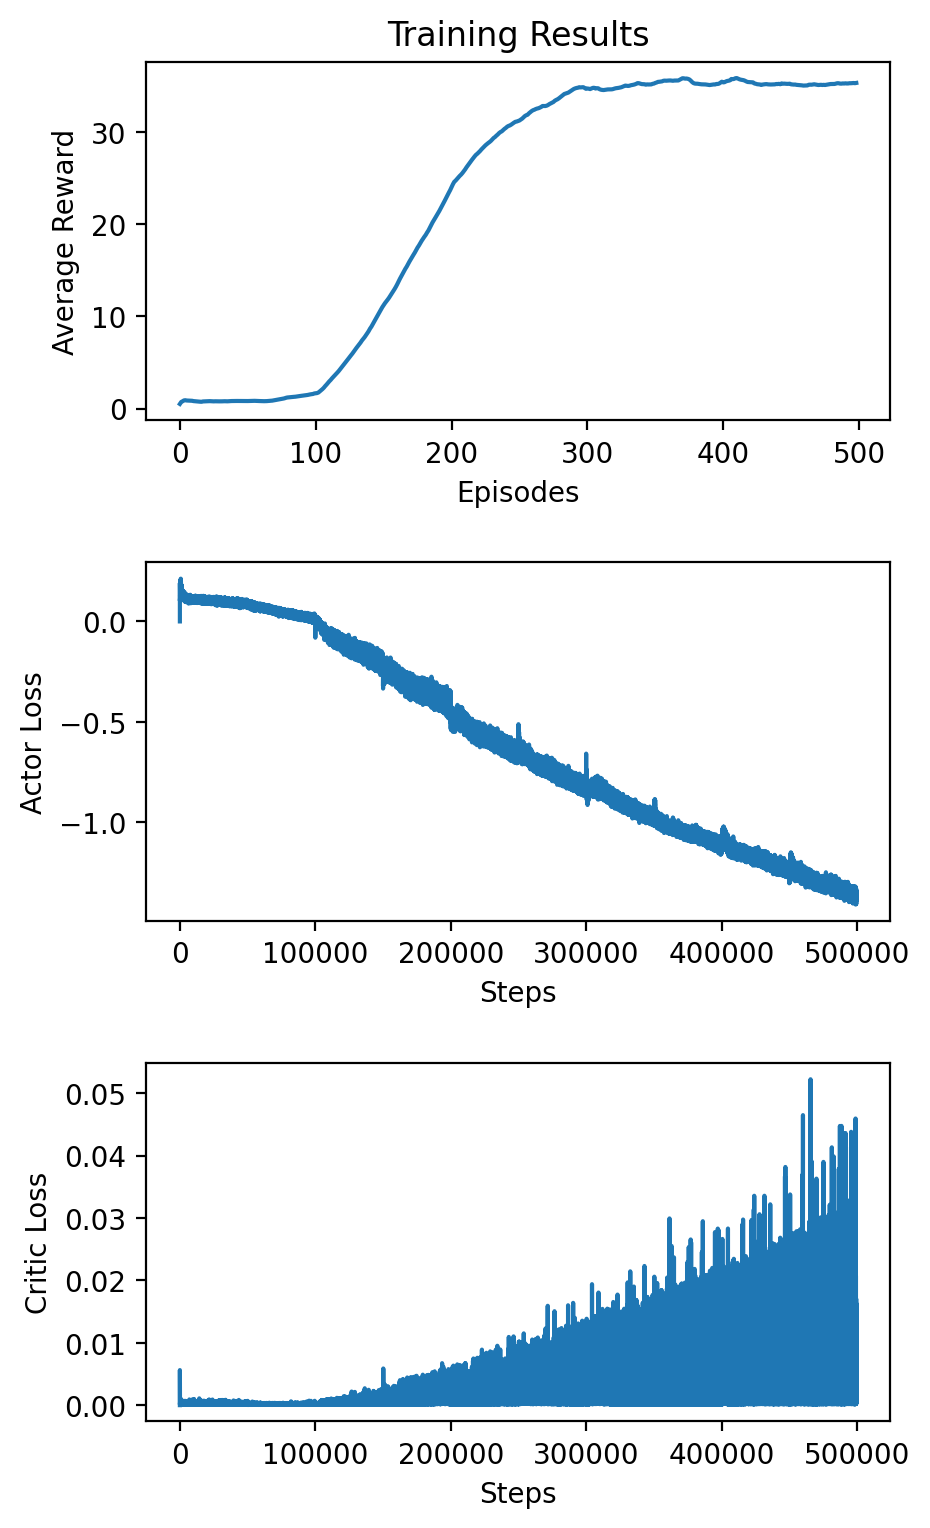

In [15]:
# plot score history
plt.ion()
fig, axarr = plt.subplots(3,1, figsize=(5,8), dpi=200)
ax1 = axarr[0]
ax1.set_title("Training Results")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Average Reward")
ax1.plot(avg_log)

# plot loss
ax2 = axarr[1]
ax2.set_xlabel("Steps")
ax2.set_ylabel("Actor Loss")
ax2.plot(agent.actor_loss_log)

ax3 = axarr[2]
ax3.set_xlabel("Steps")
ax3.set_ylabel("Critic Loss")
ax3.plot(agent.critic_loss_log)

fig.tight_layout(pad=2.0)
plt.show()

### 5. Simulate a trained agent

In this section, you will load the network weights from a pre-trained agent and use them to simulate the environment. To simulate the agent from an immediate training session, comment the line of code where the weights are loaded from the **checkpoint.pth** file.

In [ ]:
# load the weights from file
agent.actor.load_state_dict(torch.load('checkpoint.pth'))

# sim options
NUM_SIMS = 1

# create DDPG agent
agent = DDPGAgent(osize, asize, seed=0)

# load the weights from file
agent.actor.load_state_dict(torch.load('checkpoint.pth'))

# Sim the agent
for sim_count in range(NUM_SIMS):

    # reset the environment
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    
    ep_reward = 0
    
    while True:
        # sample action from the current policy
        actions = agent.get_action(states)
        
        # step the environment
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards 
        dones = env_info.local_done
        
        states = next_states
        ep_reward += np.sum(rewards)
        
        # terminate if done
        if np.any(dones):
            break
    
    # scale episode reward
    ep_reward /= 20
    
    # print training progress
    print('Sim: {:4d} \tCumulative Reward: {:6.2f}'.format(sim_count+1, ep_reward))

When finished, you can close the environment.

In [ ]:
env.close()